In [1]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
#rc('text', usetex=True)
#params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
#plt.rcParams.update(params)
#plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

In [5]:
bc_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
bu_tree = uproot.open('root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
tree_gen = uproot.open("root://eospublic.cern.ch//eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [6]:
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
df_gen = tree_gen.arrays(library="pd", how="zip")

In [7]:
N_Z0 = 5*10**(12)
BF_Zbb = 0.1512
f_Bc = 0.0004
f_Bu = 0.43
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [8]:
spline_MVA1_log = pickle.load(open('../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
spline_MVA2_log = pickle.load(open('../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

In [9]:
def S_cut(initial_eff_signal, cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion*initial_eff_signal*cut_eff

def B_incl_cut(initial_eff_incl_bkg, cut_eff) :
    return N_Z0*BF_Zbb*2*initial_eff_incl_bkg*cut_eff

def B_cut(initial_eff_signal, cut_eff) :
    return N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion*initial_eff_signal*cut_eff

In [10]:
var1 = 'EVT_MVA1'
var2 = 'EVT_MVA2'

MVA1_cut_log = -np.log(1-0.95)
MVA2_cut_log = -np.log(1-0.95)
max_cut_1_log = 9
max_cut_2_log = 8

bc_init = bc_df[bc_df[var2]> 0.95]
bc_init = bc_init[bc_init[var1]> 0.95]
bu_init = bu_df[bu_df[var2]> 0.95]
bu_init = bu_init[bu_init[var1]> 0.95]
bb_init = bb_df[bb_df[var2]> 0.95]
bb_init = bb_init[bb_init[var1]> 0.95]

nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_init = len(bc_init)
nb_bu_init = len(bu_init)
nb_bb_init = len(bb_init)
nb_bb1_init = interpolate.splint(MVA1_cut_log, max_cut_1_log, spline_MVA1_log)
nb_bb2_init = interpolate.splint(MVA2_cut_log, max_cut_2_log, spline_MVA2_log)

initial_eff_bc = nb_bc_init / nb_total_events
initial_eff_bu = nb_bu_init / nb_total_events
initial_eff_bb = nb_bb_init / nb_total_events

In [11]:
best_MVA1_cut = 0.99986
best_MVA2_cut = 0.99634

best_MVA1_cut_log = -np.log(1-best_MVA1_cut)
best_MVA2_cut_log = -np.log(1-best_MVA2_cut)
max_cut_1_log = 9
max_cut_2_log = 8

bu_cut = bu_df[bu_df['EVT_MVA1'] > best_MVA1_cut]
bu_cut = bu_cut[bu_cut['EVT_MVA2'] > best_MVA2_cut]
bc_cut = bc_df[bc_df['EVT_MVA1'] > best_MVA1_cut]
bc_cut = bc_cut[bc_cut['EVT_MVA2'] > best_MVA2_cut]
bb_cut = bb_df[bb_df['EVT_MVA1'] > best_MVA1_cut]
bb_cut = bb_cut[bb_cut['EVT_MVA2'] > best_MVA2_cut]

nb_bc_cut = len(bc_cut)
nb_bu_cut = len(bu_cut)
nb_bb_cut_i1 = interpolate.splint(best_MVA1_cut_log, max_cut_1_log, spline_MVA1_log)
nb_bb_cut_i2 = interpolate.splint(best_MVA2_cut_log, max_cut_2_log, spline_MVA2_log)

eff_bc = nb_bc_cut/nb_bc_init 
eff_bu = nb_bu_cut/nb_bu_init 
eff_bb = (nb_bb_cut_i1/nb_bb1_init) * (nb_bb_cut_i2/nb_bb2_init)


In [12]:
N_BC = S_cut(initial_eff_bc, eff_bc)
N_BU = B_cut(initial_eff_bu, eff_bu)
N_BB = B_incl_cut(initial_eff_bb, eff_bb)

In [13]:
print(N_BC)
print(N_BU)
print(N_BB)

4009.2649482816005
241.47796710240002
3615.187009498297


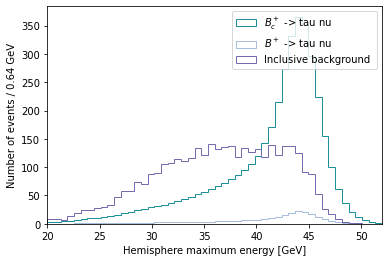

[]

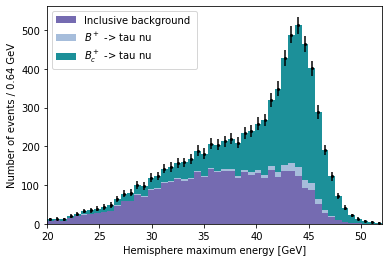

In [24]:
variable = 'EVT_ThrustEmax_E'

nb_bins = 50
min_bin = 20
max_bin = 52

name_bc = "$B_c^+$ -> tau nu "
name_bu = "$B^+$ -> tau nu"
name_bb = "Inclusive background "

counts_bc, bins_bc = np.histogram(bc_init[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_init[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_init[variable], bins = nb_bins, range = (min_bin, max_bin))

counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB

plt.figure()
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= "#1c9099", label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= "#a6bddb", label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= "#756bb1", label=name_bb)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

x = [bins_bc[:-1], bins_bu[:-1], bins_bb[:-1]]
bins = bins_bc
weights = [counts_bb, counts_bu, counts_bc]
colour = ["#756bb1","#a6bddb","#1c9099"]
name = [name_bb, name_bu, name_bc]

plt.figure()
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[2])
plt.errorbar(bin_centres, counts[2], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.legend()
plt.plot()

In [ ]:
#!pip install zfit

In [25]:
import zfit

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [26]:
nb_bins = 50
min_bin = 20
max_bin = 52

var = 'EVT_ThrustEmax_E'

name_bc = r"$B_c^+ \rightarrow \tau^+ \nu_\tau$"
name_bu = r"$B^+ \rightarrow \tau^+ \nu_\tau$"
name_bb = r"Inclusive background $Z^0 \rightarrow b\bar{b}$"

##### Toy samples

In [43]:
#sample_process1 = bc_init[var]/len(bc_init[var])*N_BC
#sample_process2 = bu_init[var]/len(bu_init[var])*N_BU
#sample_process3 = bb_init[var]/len(bb_init[var])*N_BB

#sample_to_fit = np.concatenate([sample_process1, sample_process2, sample_process3])

[]

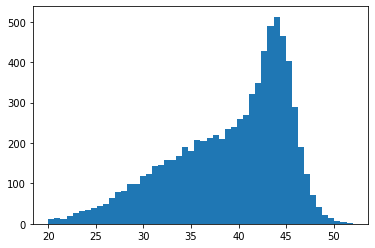

In [60]:
#sample_hist, bins_edges = np.histogram(sample_to_fit, bins = nb_bins, range = (min_bin, max_bin))                                    

plt.figure()
sample_hist, bins_edges, _ = plt.hist(bin_edges[:-1], bins=bin_edges, weights = counts[2])
plt.plot()

In [61]:
print(bin_edges)
print(bins_edges)
print(sample_hist)

[20.   20.64 21.28 21.92 22.56 23.2  23.84 24.48 25.12 25.76 26.4  27.04
 27.68 28.32 28.96 29.6  30.24 30.88 31.52 32.16 32.8  33.44 34.08 34.72
 35.36 36.   36.64 37.28 37.92 38.56 39.2  39.84 40.48 41.12 41.76 42.4
 43.04 43.68 44.32 44.96 45.6  46.24 46.88 47.52 48.16 48.8  49.44 50.08
 50.72 51.36 52.  ]
[20.   20.64 21.28 21.92 22.56 23.2  23.84 24.48 25.12 25.76 26.4  27.04
 27.68 28.32 28.96 29.6  30.24 30.88 31.52 32.16 32.8  33.44 34.08 34.72
 35.36 36.   36.64 37.28 37.92 38.56 39.2  39.84 40.48 41.12 41.76 42.4
 43.04 43.68 44.32 44.96 45.6  46.24 46.88 47.52 48.16 48.8  49.44 50.08
 50.72 51.36 52.  ]
[ 11.39111537  13.20811586  11.62504258  19.9005972   26.48965946
  32.58088736  34.63939639  39.28182862  43.35693599  48.85741732
  64.47379793  77.89403066  80.75465767  99.64017005  97.81702793
 119.29405557 123.31109359 142.40889167 146.53177101 157.83600413
 158.55216894 166.66137159 189.06960997 181.13402474 206.44260204
 203.71263083 212.79852328 220.09214274 209.9077

##### Building the templates

In [53]:
print(bins_edges)

[ 11.39111537  13.20811586  11.62504258  19.9005972   26.48965946
  32.58088736  34.63939639  39.28182862  43.35693599  48.85741732
  64.47379793  77.89403066  80.75465767  99.64017005  97.81702793
 119.29405557 123.31109359 142.40889167 146.53177101 157.83600413
 158.55216894 166.66137159 189.06960997 181.13402474 206.44260204
 203.71263083 212.79852328 220.09214274 209.90776876 234.70780059
 238.66074523 258.60811567 268.51026469 320.73368998 349.14266004
 426.99834986 488.23482275 512.27600078 464.12017637 401.69282333
 288.85128836 190.37809891 122.23825306  71.93809725  41.08132019
  21.78096258  13.64603391   6.47462769   4.1926141    1.99984027]


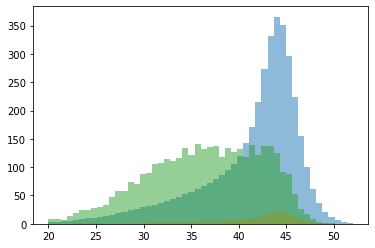

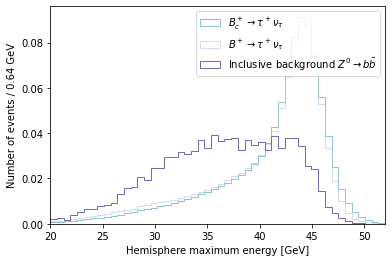

In [67]:
#simulated_sample_process1 = bc_init[var] #bc
#simulated_sample_process2 = bu_init[var] #bu
#simulated_sample_process3 = bb_init[var] #bb

#template_process1, _ = np.histogram(simulated_sample_process1, bins = bin_edges)
#template_process2, _ = np.histogram(simulated_sample_process2, bins = bin_edges)
#template_process3, _ = np.histogram(simulated_sample_process3, bins = bin_edges)

template_process1, _, _ = plt.hist(bins_bc[:-1], bins_edges, weights=counts_bc, alpha=0.5)
template_process2, _, _ = plt.hist(bins_bu[:-1], bins_edges, weights=counts_bu, alpha=0.5)
template_process3, _, _ = plt.hist(bins_bb[:-1], bins_edges, weights=counts_bb, alpha=0.5)

# Normalisation
template_process1 = template_process1/np.sum(template_process1)
template_process2 = template_process2/np.sum(template_process2)
template_process3 = template_process3/np.sum(template_process3)

plt.figure()
plt.hist(bins_edges[:-1], bins_edges, weights=template_process1, histtype='step', color= "#1c9099", alpha=0.5, label=name_bc)
plt.hist(bins_edges[:-1], bins_edges, weights=template_process2, histtype='step', color= "#a6bddb", alpha=0.5, label=name_bu)
plt.hist(bins_edges[:-1], bins_edges, weights=template_process3, histtype='step', color= "#756bb1", label=name_bb)
plt.legend()
plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]")
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)))
plt.show()

##### Templates fits

In [68]:
def get_template(yield_sig, yield_incl_bkg):
  return yield_sig*template_process1 + N_BU*template_process2 + yield_incl_bkg*template_process3

In [69]:
def binned_nll(template, sample_hist):
  return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1e-14) / (template + 1e-14)))
  # 1e-14 added in case there are empty bins

def loss(x):
  # by default, `x` is an `OrderedSet` of
  # zfit parameters.
  x = np.array(x)

  print("Value of the parameters", x) # can be commented out, just to see how x evolves during 
  # the minimisation
  
  # The first parameter is the yield of the first template
  yield_sig = x[0]
  # The second parameter is the yield of the third template
  yield_incl_bkg = x[1]

  template = get_template(yield_sig, yield_incl_bkg)

  nll = binned_nll(template, sample_hist)
  return nll

loss.errordef = 0.5 # 0.5 for a log-likelihood
# We would set this parameter at 1 for a chi2 loss function.

##### Initial parameters

In [85]:
initial_yield_sig = 9000 #N_BC
initial_yield_incl_bkg = 9000 #N_BB
initial_params = [initial_yield_sig, initial_yield_incl_bkg]

##### Creating a minimiser

In [86]:
minimiser = zfit.minimize.Minuit(verbosity=5)

In [87]:
zfit.run.set_autograd_mode(False)
zfit.run.set_graph_mode(False)

In [88]:
result = minimiser.minimize(loss, initial_params)
param_hesse = result.hesse()

Value of the parameters [9000. 9000.]
Value of the parameters [9003.8112195 9000.       ]
Value of the parameters [8996.1887805 9000.       ]
Value of the parameters [9007.92122417 9000.        ]
Value of the parameters [8992.07877583 9000.        ]
Value of the parameters [9000.        9003.8112195]
Value of the parameters [9000.        8996.1887805]
Value of the parameters [9000.         9008.05504118]
Value of the parameters [9000.         8991.94495882]
Value of the parameters [-10755.95610126 -11803.03969359]


<ipython-input-69-6aa00ce06d29>:2: RuntimeWarning: invalid value encountered in log
  return np.sum(template - sample_hist + sample_hist * np.log((sample_hist + 1e-14) / (template + 1e-14)))


Value of the parameters [ -837.32052017 -1358.70743035]
Value of the parameters [4163.57137654 3907.23627278]
Value of the parameters [4164.36349896 3907.23627278]
Value of the parameters [4162.77925412 3907.23627278]
Value of the parameters [4163.78677022 3907.23627278]
Value of the parameters [4163.35598286 3907.23627278]
Value of the parameters [4163.57137654 3908.0417769 ]
Value of the parameters [4163.57137654 3906.43076866]
Value of the parameters [4163.57137654 3907.44943275]
Value of the parameters [4163.57137654 3907.0231128 ]
Value of the parameters [3780.35601995 3250.28365664]
Value of the parameters [4004.21169768 3634.04325967]
Value of the parameters [4004.25473366 3634.04325967]
Value of the parameters [4004.1686617  3634.04325967]
Value of the parameters [4004.21169768 3634.08584928]
Value of the parameters [4004.21169768 3634.00067007]
Value of the parameters [4016.3105966 3607.9918861]
Value of the parameters [4013.64527616 3613.73085946]
Value of the parameters [401

In [89]:
print(result.info['original'])
print(result.params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 5.457e-10                  │              Nfcn = 48               │
│ EDM = 5.46e-10 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name           value    minuit_hesse    at limit
-----------  -------  --------------  ----------
autoparam_8     4009     +/- 1.1e+02       False
autoparam_9     3615     +/- 1.1e+02       False


In [90]:
print(N_BC)
print(N_BU)
print(N_BB)

4009.2649482816005
241.47796710240002
3615.187009498297
